<h1> Assignment #2 </h1>

You have to move several cargos across the gridworld into a common desirable rectangle area. There are several cargos, you can move each of them either horizontally or vertically by one cell up or down. Size of the overall world may vary, as well as placement of the cargos and desirable area. The game ends when all the cargos are in the desirable area and do not overlap.

Reward function: 
* for each cell of cargo placed in desirable area in the end of the turn, reward is $+1$
* for each cell where cargos overlap in the end of the turn, reward is $-1$

---

Submit `{name}_{surname}.zip` file containing:
* `{name}_{surname}.ipynb` with code for learning your model using your realisation of environment
* `{name}_{surname}.py` script with `complete_task(path_to_infile, path_to_outfile)` function
* report `{name}_{surname}.pdf`, containing information on:
  * choice of the environment representation used for the model training
  * way of training environment generation
  * architecture choice for the neural network you use for the prediction

## Input of the script

`{infile}.txt` file with the field description. Elements of the field are separated by space. For example: 

```
0 0 2 2 0
0 r r r 0
0 r r r 1
0 r r r 1
0 0 0 0 1
```

* `0` - blank space, we may move objects here
* `r` - desirable area, we should move objects here
* `1`, `2`, ... - actual object shapes, does not change, moved as a solid object

In your output file, you have to record lines in the following manner: `{id} {D/U/R/L}`. For the given example, possible sequence of steps is:
```
2 D
1 L
1 U
2 L
```

Here the rewards are: 
1. +2 for 2 cells of `2`
2. +4 for 2 cells of `2` and 2 cells of `1`
3. +3 (= +4 - 1) for 2 cells of `2` and 2 cells of `1` and -1 overlapping cell 
4. **The end**

## Output of the script

Sequence of actions, written in `{outfile}.txt`. Rewrite it after each 100th action, please, and after you rich the final position.

# Solution

In [ ]:
from typing import List, Tuple, Dict
from functools import lru_cache

import numpy as np
import random

import torch.nn as nn
import torch

from tqdm.auto import tqdm
from matplotlib import pyplot as plt

In [ ]:
STATE_SIZE = 9
ACTIONS_SIZE = 4
HIDDEN_LAYER_SIZE = 2 ** STATE_SIZE


class DQN(nn.Module):
    def __init__(self):
        super().__init__()
        self.input = nn.Linear(STATE_SIZE, HIDDEN_LAYER_SIZE)
        self.hidden_1 = nn.Linear(HIDDEN_LAYER_SIZE, HIDDEN_LAYER_SIZE // 2)
        self.hidden_2 = nn.Linear(HIDDEN_LAYER_SIZE // 2, HIDDEN_LAYER_SIZE // 2)
        self.output = nn.Linear(HIDDEN_LAYER_SIZE // 2, ACTIONS_SIZE)

        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=0)
    

    def forward(self, x):
        x = self.input(x)
        x = self.relu(self.hidden_1(x))
        x = self.relu(self.hidden_2(x))
        x = self.output(x)
        
        return self.softmax(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DQNModel = DQN().to(device)

In [ ]:
class GridWorld:
    
    class Cargo:
        def __init__(self, name: int, coordinates: List[Tuple], world):
            self.name = name
            self.coordinates = coordinates
            self.init_coordinates = self.coordinates[:] # for resetting world
            self.boundaries = self.__get_cargo_boundaries()
            self.world = world
            self.reward = 0
        

        def reset(self):
            """
            Возвращаем груз в исходное положение для обучения в следующей эпохе.
            """
            self.coordinates = self.init_coordinates[:]
            self.boundaries = self.__get_cargo_boundaries()
            self.reward = 0


        def move(self, action):
            """
            Двигаем груз в одном из четырёх направлений, если возможно.
            """
            actions = {
                "L": (0, -1),
                "R": (0, +1),
                "U": (-1, 0),
                "D": (+1, 0)
            }

            new_coords = []
            for cell in self.coordinates:
                r, c = cell
                dr, dc = actions[action]
                
                # если не можем двигаться туда, то остаёмся на месте
                if self.is_move_possible(action):
                    new_coords.append((r + dr, c + dc))
                else:
                    return self.coordinates
            
            # обновляем границы груза, чтобы не вычислять их заново за О(n)
            (ur, uc), (dr, dc) = self.boundaries
            ur, uc = ur + actions[action][0], uc + actions[action][1]
            dr, dc = dr + actions[action][0], dc + actions[action][1]
            self.boundaries = (ur, uc), (dr, dc)

            
            self.coordinates = new_coords
            return new_coords


        def is_move_possible(self, action) -> bool:
            actions = {
                "L": (0, -1),
                "R": (0, +1),
                "U": (-1, 0),
                "D": (+1, 0)
            }
            rd, cd = actions[action]
            cargo = [(r + rd, c + cd) for r, c in self.coordinates]
            
            in_boundaries = all(
                map(lambda el: 0 <= el[0] < self.world.r and 0 <= el[1] < self.world.c, cargo)
            )
            if not in_boundaries:
                return False
            
            return True


        def __get_cargo_boundaries(self) -> Tuple:
            """
            Возвращает координаты верхнего левого и правого нижнего углов
            груза, достроенного до прямоугольника.
            """
            ur = min(self.coordinates, key=lambda x: x[0])[0]
            uc = min(self.coordinates, key=lambda x: x[1])[1]
            dr = max(self.coordinates, key=lambda x: x[0])[0]
            dc = max(self.coordinates, key=lambda x: x[1])[1]
            return (ur, uc), (dr, dc)


    def __init__(self, n: int, m: int,
                 default_reward: int,
                 cargos: List[Tuple[int, int, int]],
                 desirable_area: List[Tuple[int, int]]):
        self.r = n # number of rows
        self.c = m # number of columns
        self.board = [(r, c) for r in range(n) for c in range(m)]
        self.cargos = self.__get_cargos(cargos)
        self.desirable_area = desirable_area
        self.default_reward = default_reward


    def reset(self):
        """
        Возвращает все грузы на их исходное местоположение.
        """
        for cargo_name in self.cargos:
            self.cargos[cargo_name].reset()


    def make_step(self) -> Tuple:
        """
        Выбирает груз, который будет передвинут и возвращает состояние
        среды относительно него.
        """
        # for cargo_name, cargo in self.cargos.items():
        #     # если у груза максимальная награда, то его не надо двигать пока,
        #     # надо поискать другой груз, который нужно подвинуть
        #     if self.compute_cargo_reward(cargo_name) != len(cargo.coordinates):
        #         return self.get_state(cargo_name), cargo_name
        
        names = tuple(self.cargos.keys())
        cargo_name = random.choice(names)
        return self.get_state(cargo_name), cargo_name


    def move_cargo(self, name, action):
        self.cargos[name].move(action)
        self.cargos[name].reward -= self.default_reward # даём награду за ход


    def get_state(self, cargo_name) -> Tuple:
        """
        Возвращает кортеж из угловых координат терминальной зоны,
        угловых координат груза (вписанного в прямоугольник),
        награду для этого груза (части в терминальной зоне
        за вычетом пересечений с этим грузом).
        """
        return (
            self.get_desirable_area_boundaries(), 
            self.cargos[cargo_name].boundaries,
            self.compute_cargo_reward(cargo_name)
        )


    def compute_cargo_reward(self, cargo_name):
        """
        Вычисляет награду по количеству вошедших в терминальную зону частей
        груза, за вычетом пересечений с другими грузами. Персечения учитываются
        по всему миру, а не только по терминальной зоне.
        """
        area_lub, area_rdb = self.get_desirable_area_boundaries()
        cells = self.cargos[cargo_name].coordinates
        in_boundaries = sum(map(lambda cell: 
                    area_lub[0] <= cell[0] <= area_rdb[0] and 
                    area_lub[1] <= cell[1] <= area_rdb[1],
                    cells))
        
        intersections = {cell: 0 for cell in cells}
        for name, cargo in self.cargos.items():
            if name == cargo_name:
                continue
            for cell in cargo.coordinates:
                if cell in intersections:
                    intersections[cell] += 1
        
        # Несколько пересечений в одной точке суммируются
        return in_boundaries - sum(intersections.values())


    def check_terminate(self) -> bool:
        """
        Проверяет входят ли все грузы в терминальную зону без пересечений.
        """
        area_lub, area_rdb = self.get_desirable_area_boundaries()
        for cargo in self.cargos.values():
            cells = cargo.coordinates
            in_boundaries = all(
                map(lambda cell: 
                    area_lub[0] <= cell[0] <= area_rdb[0] and 
                    area_lub[1] <= cell[1] <= area_rdb[1],
                    cells)
            )
            if not in_boundaries:
                return False
        
        intersections = set()
        for cargo in self.cargos.values():
            for cell in cargo.coordinates:
                if cell not in intersections:
                    intersections.add(cell)
                else:
                    return False

        return True


    @lru_cache()
    def get_desirable_area_boundaries(self) -> Tuple:
        """
        Возвращает координаты правого верхнего и левого нижнего углов,
        по которым можно уникально определить расположение терминальной зоны.
        """
        return min(self.desirable_area), max(self.desirable_area)


    def __get_cargos(self, cargos) -> Dict[int, Cargo]:
        """
        Создаёт список объектов грузов по именованным координатам.
        """
        names = set()
        for name, *_ in cargos:
            names.add(name)
        
        tf_cargos = {}
        for name in names:
            coordinates = list(
                map(lambda x: (x[1], x[2]), filter(lambda x: x[0] == name, cargos))
            )
            tf_cargos[name] = (self.Cargo(name, coordinates, self))

        return tf_cargos


    def __str__(self):
        board = np.full((self.r, self.c), '0', dtype=str)
        
        for cell in self.desirable_area:
            board[cell] = 'r'
        
        for name, cargo in self.cargos.items():
            for cell in cargo.coordinates:
                board[cell] = str(cargo.name)
        
        return str(board)


    def __repr__(self):
        return str(self)

In [ ]:
def load_world(n, m, grid) -> GridWorld:
    cargos = []
    desirable_area = []
    for i in range(n):
        for j in range(m):
            if grid[i][j] == 'r':
                desirable_area.append((i, j))
            elif grid[i][j] != '0':
                cargos.append((int(grid[i][j]), i, j))
    
    return GridWorld(n, m, default_reward=0, cargos=cargos, desirable_area=desirable_area)

In [ ]:
# 0 0 2 2 0
# 0 r r r 0
# 0 r r r 1
# 0 r r r 1
# 0 0 0 0 1

# cargos = [(2, 0, 2), (2, 0, 3)]#, (1, 2, 4), (1, 3, 4), (1, 4, 4)]
# desirable_area = [(6, 0), (6, 1), (7, 0), (7, 1)]
# desirable_area = [(3, 1), (3, 2), (3, 3), (2, 1), (2, 2), (2, 3), (4, 1), (4, 2), (4, 3)]

# world = GridWorld(5, 5, default_reward=-1, cargos=cargos, desirable_area=desirable_area)

grid = []
with open(f'infile.txt', 'r') as f:
    for line in f:
        grid.append(line.split())

n, m = len(grid), len(grid[0])
world = load_world(n, m, grid)
# world.move_cargo(2, 'R')
# print(world.get_desirable_area_boundaries())
# print(world.cargos[1].get_cargo_boundaries())
# world.move_cargo(1, 'L')
# world.move_cargo(1, 'U')
# world.move_cargo(2, 'L')
# world.move_cargo(2, 'D')
# print(world.check_terminate())
# print(world.compute_cargo_reward(2))
# print(world.cargos[2].get_cargo_boundaries())
print(world)

[['0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0']
 ['0' 'r' 'r' 'r' '0' '0']
 ['0' 'r' 'r' 'r' '0' '0']
 ['0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' '2' '2']
 ['0' '0' '0' '0' '2' '2']]


## Цикл обучения

In [ ]:
MAX_TRAJECTORIES = 100
MAX_STEPS = 1000

learning_rate = 0.003
model = DQNModel
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
gamma = 0.5
score = []

In [ ]:
def flatten_state(state):
    if isinstance(state, tuple):
        for x in state:
            yield from flatten_state(x)
    else:
        yield state

count_success = 0
for trajectory in tqdm(range(MAX_TRAJECTORIES)):
    world.reset()
    curr_state, cargo_name = world.make_step()
    curr_state = np.array(list(flatten_state(curr_state)))
    transitions = []
    # iterating the trajectory
    for t in range(MAX_STEPS):
        act_prob = model(torch.from_numpy(curr_state).float()).data.numpy()
        directions = ['L', 'R', 'U', 'D']
        action = np.random.choice(
            np.array(directions),
            p=act_prob
            )
        while len(directions) > 1 and not world.cargos[cargo_name].is_move_possible(action):
            escape = np.argmax(act_prob)
            directions.pop(escape)
            escape_prob = act_prob[escape]
            act_prob = np.array([act_prob[i] for i in range(len(act_prob)) if i != escape])
            act_prob += escape_prob / len(directions)
            action = np.random.choice(
                np.array(directions),
                p=act_prob
            )
            # action = directions[np.argmax(act_prob)]
        # print(f"{cargo_name} {action}")
        prev_state = curr_state
        prev_cargo_name = cargo_name
        world.move_cargo(cargo_name, action) # реализуем действие
        transitions.append((prev_state, prev_cargo_name, action, t + 1))

        curr_state, cargo_name = world.make_step() # выбираем новый случайный груз
        curr_state = np.array(list(flatten_state(curr_state)))

        # проверка для всех грузов, может проверять только для одного?
        if world.check_terminate():
            break
    
    # print(world)
    # iters until fallen
    score.append(len(transitions))
    reward_batch = torch.Tensor([s[8] for (s, n, a, t) in 
                   transitions]).flip(dims=(0,)) # reward is 9th position
    
    # fast computations using top-down approach
    batch_Gvals = []
    batch_Gvals = [reward_batch[len(transitions) - 1]]
    for i in range(1, len(transitions)):
        batch_Gvals.append(
            batch_Gvals[i - 1] * gamma + reward_batch[len(transitions) - i - 1]
            )
    batch_Gvals.reverse()

    expected_returns_batch = torch.FloatTensor(batch_Gvals)
    # expected_returns_batch /= expected_returns_batch.min()

    
    state_batch = torch.Tensor(np.array([s for (s, n, a, r) in transitions]))
    action_map = {'L': 0, 'R': 1, 'U': 2, 'D': 3}
    action_batch = torch.Tensor(np.array([action_map[a] for (s, n, a, r) in transitions]))

    pred_batch = model(state_batch)
    prob_batch = pred_batch.gather(dim=1,index=action_batch
                 .long().view(-1,1)).squeeze()

    # so, compute the gradient
    loss = -torch.sum(torch.log(prob_batch) * expected_returns_batch) 
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  0%|          | 0/100 [00:00<?, ?it/s]

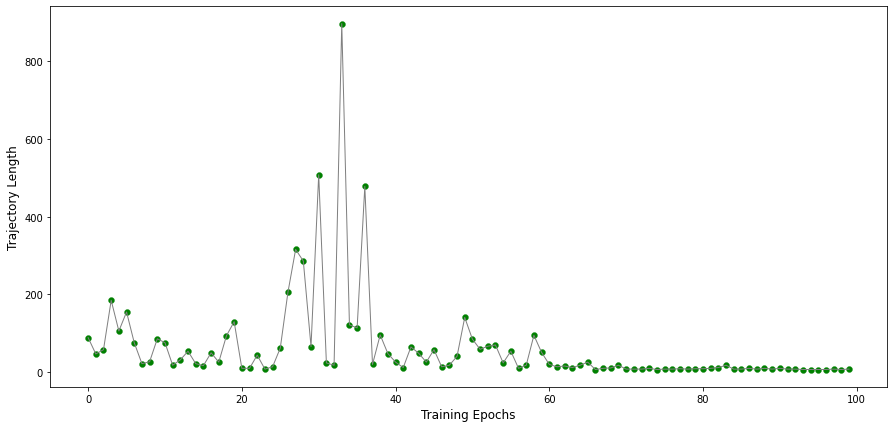

In [ ]:
def running_mean(x):
    N = MAX_TRAJECTORIES // 2
    kernel = np.ones(N)
    conv_len = x.shape[0]-N
    y = np.zeros(conv_len)

    shift = int(N/2)
    for i in range(shift, conv_len + shift):
        y[i - shift] = kernel @ x[i-shift:i+shift]
        y[i - shift] /= N
    return y

score = np.array(score)
avg_score = running_mean(score)

plt.figure(figsize=(15,7))
plt.ylabel("Trajectory Length",fontsize=12)
plt.xlabel("Training Epochs",fontsize=12)
plt.plot(score, color='gray' , linewidth=1)
# plt.plot(np.arange(0, len(avg_score)), avg_score, color='blue', linewidth=3)
plt.scatter(np.arange(score.shape[0]),score, 
            color='green' , linewidth=0.3)
plt.show()

In [ ]:
print(score)

[ 89  47  58 185 106 155  76  22  27  86  76  18  32  54  22  17  50  26
  94 130  10  10  44   8  14  62 206 316 286  66 508  24  18 897 122 114
 478  20  96  48  26  12  65  49  26  58  14  18  41 141  85  59  67  70
  24  54  10  18  95  51  20  14  16  12  18  26   7  10  11  18   8   8
   8  10   7   8   8   9   8   9   9  10  12  18   8   8  10   8  10   8
  10   8   8   7   7   7   7   8   7   8]


In [ ]:
torch.save(model.state_dict(), 'model_v1.pt')

## Работа с файловым вводом/выводом

In [ ]:
def complete_task(infile, outfile):
    grid = []
    with open(f'{infile}.txt', 'r') as f:
        for line in f:
            grid.append(line.split())
    
    n, m = len(grid), len(grid[0])
    world = load_world(n, m, grid)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = DQN().to(device) 
    model.load_state_dict(torch.load('model_v1.pt'))
    model.eval()

    while not world.check_terminate():
        curr_state, cargo_name = world.make_step()
        curr_state = np.array(list(flatten_state(curr_state)))
        act_prob = model(torch.from_numpy(curr_state).float()).data.numpy()
        directions = ['L', 'R', 'U', 'D']
        action = directions[np.argmax(act_prob)]
        # action = np.random.choice(
        #     np.array(['L', 'R', 'U', 'D']),
        #     p=act_prob
        #     )
        while len(directions) > 1 and not world.cargos[cargo_name].is_move_possible(action):
            escape = np.argmax(act_prob)
            directions.pop(escape)
            escape_prob = act_prob[escape]
            act_prob = np.array([act_prob[i] for i in range(len(act_prob)) if i != escape])
            act_prob += escape_prob / len(directions)
            # action = directions[np.argmax(act_prob)]
            action = np.random.choice(
                np.array(directions),
                p=act_prob
            )
        print(f"{cargo_name} {action}")
        world.move_cargo(cargo_name, action) # реализуем действие

    # res = ...
    # with open(f'{outfile}.txt') as f:
    #     pass


In [ ]:
# with open('infile.txt', 'w') as f:
#     f.write(
# """0 0 2 2 0
# 0 0 0 0 0
# 0 r r r 0
# 0 r r r 0
# 0 r r r 0""")

In [ ]:
complete_task('infile', 'outfile')

2 L
2 U
2 U
2 U
2 U
2 L
2 U
